In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

from sklearn.metrics import f1_score

import time
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
from googletrans import Translator
from deep_translator import GoogleTranslator
import random

#nltk.download('wordnet')
#nltk.download('omw-1.4')

translator = Translator()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df_data = pd.read_csv('MEISD/MEISD_text.csv')

In [3]:
df_data.head()

,TV Series,Utterances,dialog_ids,uttr_ids,seasons,episodes,start_times,end_times,sentiment,emotion,intensity,emotion2,intensity2,emotion3,intensity3
0,GA,look around you,1,0,1,1,00:02:27:589,00:02:28:567,neutral,neutral,NaN,NaN,NaN,NaN,NaN
1,GA,say hello to your competition,1,1,1,1,00:02:28:910,00:02:30:513,neutral,neutral,NaN,NaN,NaN,NaN,NaN
2,GA,eight of you will switch to an easier specialty,1,2,1,1,00:02:31:387,00:02:34:060,neutral,neutral,NaN,NaN,NaN,NaN,NaN
3,GA,five of you will crack under the pressure,1,3,1,1,00:02:34:134,00:02:36:002,neutral,neutral,NaN,NaN,NaN,NaN,NaN
4,GA,two of you will be asked to leave,1,4,1,1,00:02:36:059,00:02:37:723,neutral,neutral,NaN,NaN,NaN,NaN,NaN


In [4]:
unique_emotions = set(df_data['emotion'].unique()) | set(df_data['emotion2'].unique()) | set(df_data['emotion3'].unique())
print(unique_emotions)

{'neutral', 'sadness', 'acceptance ', 'fear ', 'Joy', 'Neutral', 'Fear', ' anger', 'Disgust', 'surprise', 'digust', 'Fera', 'faer', 'Sadness ', 'anger', 'Neutral ', 'an', 'Anger', 'neutral ', 'sur', 'acceptance', 'asadness', 'like', 'Fear ', ' surprise', 'Sadness', ' sadness', 'Surprise ', 'ANGER', ' disgust', 'anger1', 'joy', 'sadnes', '  disgust', 'Surprise', 'l', 'disgust', 'sadness ', nan, 'fear'}


In [5]:
emotion_map = {
    'neutral': 0, 'Neutral': 0, 'Neutral ': 0, 'neutral ': 0,
    'acceptance': 1, 'acceptance ': 1,
    'disgust': 2, 'Disgust': 2, ' disgust': 2, '  disgust': 2, 'digust': 2,
    'surprise': 3, 'Surprise': 3, ' surprise': 3, 'Surprise ': 3, 'sur': 3,
    'joy': 4, 'Joy': 4, 'like': 4,
    'sadness': 5, 'Sadness': 5, ' sadness': 5, 'Sadness ': 5, 'sadness ': 5, 'sadnes': 5, 'asadness': 5,
    'anger': 6, 'Anger': 6, ' anger': 6, 'ANGER': 6, 'anger1': 6, 'an': 6,
    'fear': 8, 'Fear': 8, 'fear ': 8, 'Fear ': 8, 'faer': 8, 'Fera': 8,
    'l': None, np.nan: None
}

data_emotion = pd.DataFrame()
data_emotion['Utterances'] = df_data['Utterances']

data_emotion['target1'] = df_data['emotion'].map(emotion_map)
data_emotion['target2'] = df_data['emotion2'].map(emotion_map)
data_emotion['target3'] = df_data['emotion3'].map(emotion_map)


def fill_nans(row):
    if row.isna().sum() == 2 and row.count() == 1:
        row = row.fillna(row.dropna().iloc[0])

    elif row.isna().sum() == 1 and row.count() == 2:
        row = row.fillna(row.dropna().iloc[0])

    return row


data_emotion[['target1', 'target2', 'target3']] = data_emotion[['target1', 'target2', 'target3']].apply(fill_nans,
                                                                                                        axis=1)

data_emotion['target1'] = data_emotion['target1'].astype(int)
data_emotion['target2'] = data_emotion['target2'].astype(int)
data_emotion['target3'] = data_emotion['target3'].astype(int)

In [6]:
data_emotion.head(50)

,Utterances,target1,target2,target3
0,look around you,0,0,0
1,say hello to your competition,0,0,0
2,eight of you will switch to an easier specialty,0,0,0
3,five of you will crack under the pressure,0,0,0
4,two of you will be asked to leave,0,0,0
5,this is your starting line,0,0,0
6,this is your arena,0,0,0
7,how well you play,0,0,0
8,that's up to you,0,0,0
9,like i said,1,2,1


In [7]:
data_emotion['combined_emotions'] = data_emotion[['target1', 'target2', 'target3']].apply(lambda x: x.dropna().unique().astype(int).tolist(), axis=1)

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder

mlb_emotion = MultiLabelBinarizer()
emotion_binarized = mlb_emotion.fit_transform(data_emotion['combined_emotions'])
emotion_df = pd.DataFrame(emotion_binarized)
emotion_df.columns = [f'emotion_{i + 1}' for i in range(emotion_df.shape[1])]


In [9]:
multi_label_binarizer_MEISD = pd.concat([data_emotion['Utterances'], emotion_df], axis=1)
multi_label_binarizer_MEISD

,Utterances,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,look around you,1,0,0,0,0,0,0,0
1,say hello to your competition,1,0,0,0,0,0,0,0
2,eight of you will switch to an easier specialty,1,0,0,0,0,0,0,0
3,five of you will crack under the pressure,1,0,0,0,0,0,0,0
4,two of you will be asked to leave,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",0,0,1,0,0,0,1,0
20013,i'll try again,0,0,1,0,0,0,1,0
20014,"please, pam, reconsider and have a bagel",0,1,1,0,0,0,0,0
20015,i have an early lunch,0,0,1,0,0,0,1,0


In [ ]:
# def to_binary_vector(row, num_classes=9):
#     vector = np.zeros(num_classes)
#     for i in range(1, 4):  # iteracja po target1, target2, target3
#         if row[f'target{i}'] < num_classes:
#             vector[row[f'target{i}']] = int(1)
#     return vector
# 
# #data_emotion['target_vector'] = data_emotion.apply(to_binary_vector, axis=1)
# #data_emotion[['Utterances', 'target_vector']].head(5)

In [ ]:
# target_array = np.array(data_emotion['target_vector'].tolist())
# label_counts = target_array.sum(axis=0)
# for idx, count in enumerate(label_counts):
#     print(f"Label {idx}: {count}")

In [ ]:
# dataset = data_emotion[['Utterances', 'target_vector']]

In [ ]:
# dataset

In [10]:
# Data Augmentation
from transformers import pipeline

# Use BERT-based masked language model to find contextually appropriate synonyms
fill_mask = pipeline("fill-mask", model="bert-base-cased")

# 1. Synonym Replacement
def synonym_replacement(text):
    words = text.split()
    new_words = words[:]
    num_replacements = max(1, len(words) // 5)  # Replace about 20% of words
    random_words = random.sample(words, num_replacements)

    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            #synonym = synonyms[0].lemmas()[0].name()  # Take first synonym
            synonym = random.choice(synonyms).lemmas()[0].name()
            if synonym != word:  # Avoid replacement if the synonym is identical
                new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)


# 2. Random Insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        new_word = random.choice(words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, new_word)
    return ' '.join(words)


# 3. Random Deletion
def random_deletion(text, p=0.3):
    words = text.split()
    if len(words) == 1:
        return text  # Avoid deleting single-word text
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if not new_words:
        return random.choice(words)  # Return one word if all words are deleted
    return ' '.join(new_words)

# 4. Back Translation
def back_translation(text, src_lang='en', mid_lang='fr', max_retries=3):
    attempt = 0
    while attempt < max_retries:
        try:
            translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
            back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
            return back_translated
        except Exception as e:
            print(f"Back translation error on attempt {attempt + 1}: {e}")
            attempt += 1
            time.sleep(1)
    raise ValueError("Back translation failed")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

In [11]:
def augment_text(text, num_augments=2):
    augmented_texts = []
    for _ in range(num_augments):
        augmentation_choice = random.choice(['synonym', 'insertion', 'deletion', 'back_translation'])
        if augmentation_choice == 'synonym':
            augmented_texts.append(synonym_replacement(text))
        elif augmentation_choice == 'insertion':
            augmented_texts.append(random_insertion(text))
        elif augmentation_choice == 'deletion':
            augmented_texts.append(random_deletion(text))
        elif augmentation_choice == 'back_translation':
            augmented_texts.append(back_translation(text))
    return augmented_texts

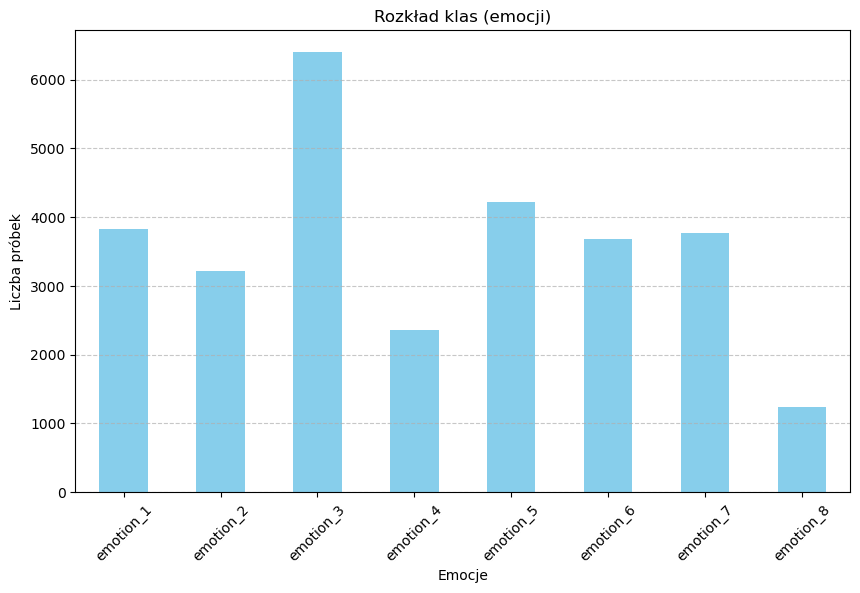

In [12]:
label_sums = multi_label_binarizer_MEISD.iloc[:, 1:].sum()

plt.figure(figsize=(10, 6))
label_sums.plot(kind='bar', color='skyblue')
plt.title('Rozkład klas (emocji)')
plt.xlabel('Emocje')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(multi_label_binarizer_MEISD, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_train, random_state=88, test_size=0.50, shuffle=True)

In [ ]:
df_train.head()

In [15]:
class_counts = df_train[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                         'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)

max_count = class_counts.max()
class_counts

emotion_1    2701
emotion_2    2236
emotion_3    4509
emotion_4    1674
emotion_5    2941
emotion_6    2563
emotion_7    2631
emotion_8     842
dtype: int64

In [17]:
augmented_data = {'Utterances': [], 'emotion_1': [], 'emotion_2': [], 'emotion_3': [],
                  'emotion_4': [], 'emotion_5': [], 'emotion_6': [], 'emotion_7': [], 'emotion_8': []}

df_train_no_emotion3 = df_train[df_train['emotion_3'] == 0]

for idx, row in tqdm(df_train_no_emotion3.iterrows(), total=len(df_train_no_emotion3), desc="Augmenting data"):
    emotions = row[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                    'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].values
    emotions = emotions.astype(int) 
    present_emotions = np.where(emotions == 1)[0]
    num_to_augment = max_count - len(present_emotions)
    num_to_augment = min(num_to_augment, 500)

    if num_to_augment > 0:
        new_texts = augment_text(row['Utterances'], num_augments=num_to_augment) 
        for new_text in new_texts:
            augmented_data['Utterances'].append(new_text)
            for i in range(8):
                augmented_data[f'emotion_{i+1}'].append(emotions[i]) 

augmented_df = pd.DataFrame(augmented_data)

df_train_augmented = pd.concat([df_train, augmented_df], ignore_index=True)

augmented_class_counts = df_train_augmented[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                                             'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0)

print(augmented_class_counts)

Augmenting data:   0%|          | 2/9502 [03:04<243:04:34, 92.11s/it]


KeyboardInterrupt: 

In [16]:
augmented_data = {'Utterances': [], 'emotion_1': [], 'emotion_2': [], 'emotion_3': [],
                  'emotion_4': [], 'emotion_5': [], 'emotion_6': [], 'emotion_7': [], 'emotion_8': []}

for idx, row in tqdm(df_train.iterrows(), total=len(df_train), desc="Augmenting data"):
    emotions = row[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                    'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].values
    emotions = emotions.astype(int) 
    present_emotions = np.where(emotions == 1)[0]
    num_to_augment = max_count - len(present_emotions)

    if num_to_augment > 0:
        new_texts = augment_text(row['Utterances'], num_augments=num_to_augment)
        for new_text in new_texts:
            augmented_data['Utterances'].append(new_text)
            for i in range(8):
                augmented_data[f'emotion_{i+1}'].append(emotions[i])

augmented_df = pd.DataFrame(augmented_data)

print(augmented_df.head())

Augmenting data:   0%|          | 0/14011 [04:36<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df_train_augmented = pd.concat([df_train, augmented_df], ignore_index=True)

print(df_train_augmented[['emotion_1', 'emotion_2', 'emotion_3', 'emotion_4',
                          'emotion_5', 'emotion_6', 'emotion_7', 'emotion_8']].sum(axis=0))

In [ ]:
print(f"Original train size: {df_train.shape}")
#print(f"Augmented train size: {augmented_df.shape}")

# df_train = augmented_df

print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

In [ ]:
# label_frequencies = df_train['label'].value_counts()
# label_frequencies_percent = df_train['label'].value_counts(normalize=True) * 100
# print(label_frequencies_percent)
# print(label_frequencies)


In [ ]:
# class_distribution = df_train['label'].value_counts(normalize=True)
# print(class_distribution)

In [ ]:
# import matplotlib.pyplot as plt
# 
# # Wykres rozkładu klas
# class_distribution.plot(kind='bar')
# plt.title('Class Distribution')
# plt.xlabel('Sentiment Class')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=0)
# plt.show()

In [ ]:
print(f"Original train size: {multi_label_binarizer_MEISD.shape}")
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

In [ ]:
# Hyperparameters
MAX_LEN = 30
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 0.001 #1e-05
THRESHOLD = 0.2 # threshold for the sigmoid

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['Utterances'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [ ]:
target_list = list(multi_label_binarizer_MEISD.columns)[1:]
target_list

In [ ]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [ ]:
next(iter(train_dataset))

In [ ]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 8)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)  

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)  

In [ ]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    #all_preds = []
    #all_labels = []

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array
        
        
        #all_preds.extend(outputs.flatten())
        #all_labels.extend(targets.flatten())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    #train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return model, float(correct_predictions) / num_samples, np.mean(losses)#, train_f1


In [ ]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    #all_preds = []
    #all_labels = []

    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()

            correct_predictions += np.sum(outputs == targets)
            num_samples += targets.size

            #all_preds.extend(outputs.flatten())
            #all_labels.extend(targets.flatten())

    avg_loss = np.mean(losses)
    #val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return float(correct_predictions) / num_samples, np.mean(losses), avg_loss#, val_f1


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f}')

    val_acc, val_loss, avg_loss = eval_model(val_data_loader, model, optimizer)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f}')


    #print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "emotion_best_model_state.bin")
        best_f1 = val_acc
        print("Saved new best model.")
     

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()


## Evaluation of the model

In [ ]:
# Model Evaluation
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join("emotion_best_model_state.bin")))
model = model.to(device)

In [ ]:
# Evaluate the model using the test data
test_acc, test_loss, avg_loss = eval_model(test_data_loader, model, optimizer)

In [ ]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            title = data["title"]
            ids = data["input_ids"].to(device, dtype = torch.long)
            mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data["targets"].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).detach().cpu()
            # thresholding at 0.5
            preds = outputs.round()
            targets = targets.detach().cpu()

            titles.extend(title)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values


In [ ]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [ ]:
# sanity check
predictions.numpy()

In [ ]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

In [ ]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples because some samples have multiple labels

print(classification_report(target_values, predictions, target_names=target_list))